<a href="https://colab.research.google.com/github/Srinivas44444/shadx/blob/main/CUSTOMER_CHURN_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# ML Prediction Libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
file_path = "WA_Fn-UseC_-Telco-Customer-Churn.csv"
telco_data = pd.read_csv(file_path)

print(telco_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
object_columns = telco_data.select_dtypes(include=['object'])

for col in object_columns.columns:
    print(f"{col} - {object_columns[col].nunique()} Unique Values")
    print(object_columns[col].unique())
    print()

# Convert Yes/No object columns to bool True/False
cols_to_convert = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in cols_to_convert:
  telco_data[col] = telco_data[col].map({'Yes': True, 'No': False}).astype(bool)

# Convert int 1/0 SeniorCitizen column to bool True/False
telco_data['SeniorCitizen'] = telco_data['SeniorCitizen'].map({1: True, 0: False}).astype(bool)

# Relocate Churn (column  of interest) to front of dataframe for clarity
telco_data.insert(0, 'Churn', telco_data.pop('Churn'))

# Remaining object columns
object_columns = telco_data.select_dtypes(include=['object'])
print("\nRemaining object columns after boolean conversions:")
print(object_columns.columns)

customerID - 7043 Unique Values
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender - 2 Unique Values
['Female' 'Male']

Partner - 2 Unique Values
['Yes' 'No']

Dependents - 2 Unique Values
['No' 'Yes']

PhoneService - 2 Unique Values
['No' 'Yes']

MultipleLines - 3 Unique Values
['No phone service' 'No' 'Yes']

InternetService - 3 Unique Values
['DSL' 'Fiber optic' 'No']

OnlineSecurity - 3 Unique Values
['No' 'Yes' 'No internet service']

OnlineBackup - 3 Unique Values
['Yes' 'No' 'No internet service']

DeviceProtection - 3 Unique Values
['No' 'Yes' 'No internet service']

TechSupport - 3 Unique Values
['No' 'Yes' 'No internet service']

StreamingTV - 3 Unique Values
['No' 'Yes' 'No internet service']

StreamingMovies - 3 Unique Values
['No' 'Yes' 'No internet service']

Contract - 3 Unique Values
['Month-to-month' 'One year' 'Two year']

PaperlessBilling - 2 Unique Values
['Yes' 'No']

PaymentMethod - 4 Unique Values
['Electronic check' 'Mai

In [5]:
telco_data['TotalCharges'] = telco_data['TotalCharges'].replace(' ', '0').astype(float)

print(telco_data['TotalCharges'].describe())

count    7043.000000
mean     2279.734304
std      2266.794470
min         0.000000
25%       398.550000
50%      1394.550000
75%      3786.600000
max      8684.800000
Name: TotalCharges, dtype: float64


In [6]:
object_columns = telco_data.select_dtypes(include=["object"])
object_columns = object_columns.drop(columns="customerID")

encoded_object_columns = pd.get_dummies(object_columns)
encoded_telco_data = pd.concat([telco_data.drop(columns=object_columns), encoded_object_columns], axis=1)

# Don't need customer IDs or Contract in encoded dataframe
encoded_telco_data = encoded_telco_data.drop(columns=["customerID"])

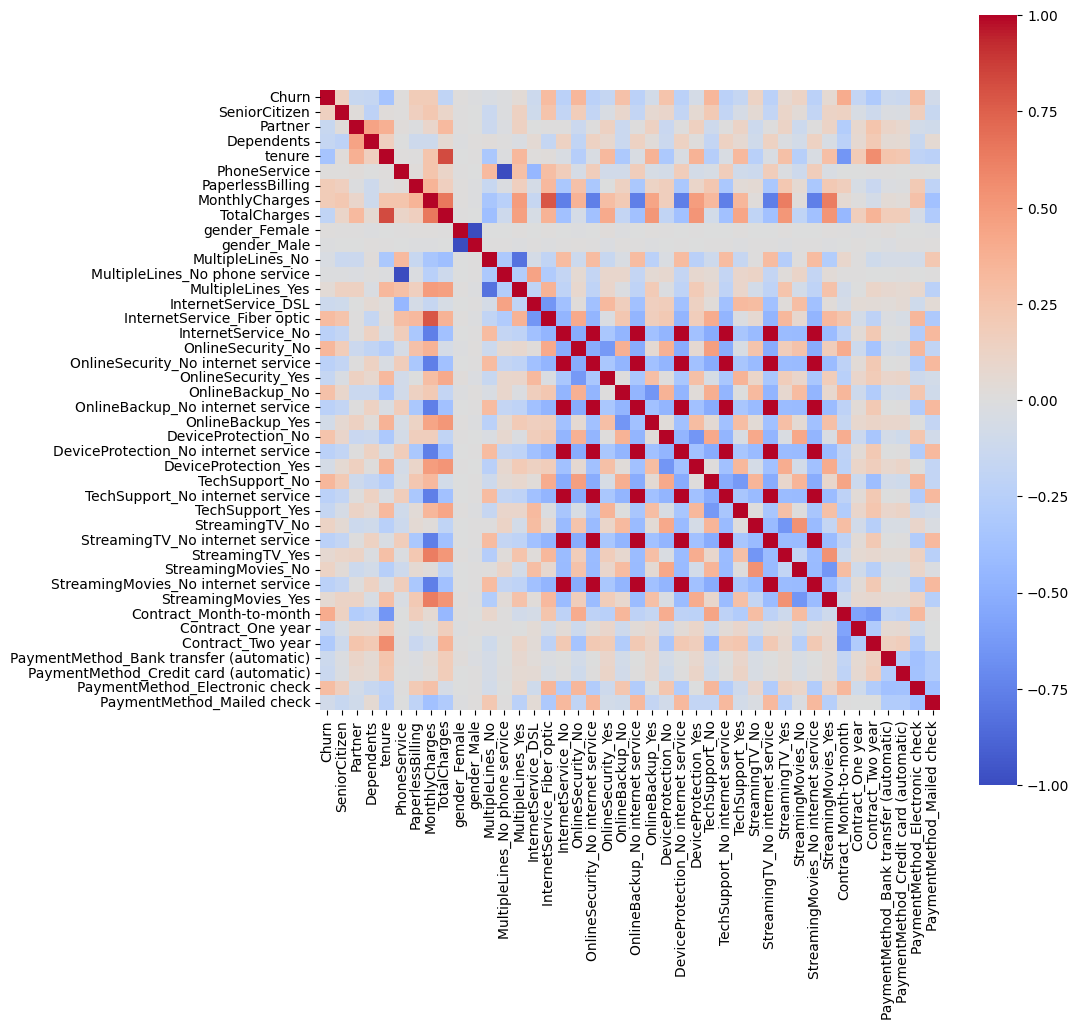

<Figure size 640x480 with 0 Axes>

In [7]:
# Correlation matrix
corr_mat = encoded_telco_data.corr()

f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_mat, cmap='coolwarm', square=True)
plt.show()
plt.clf()

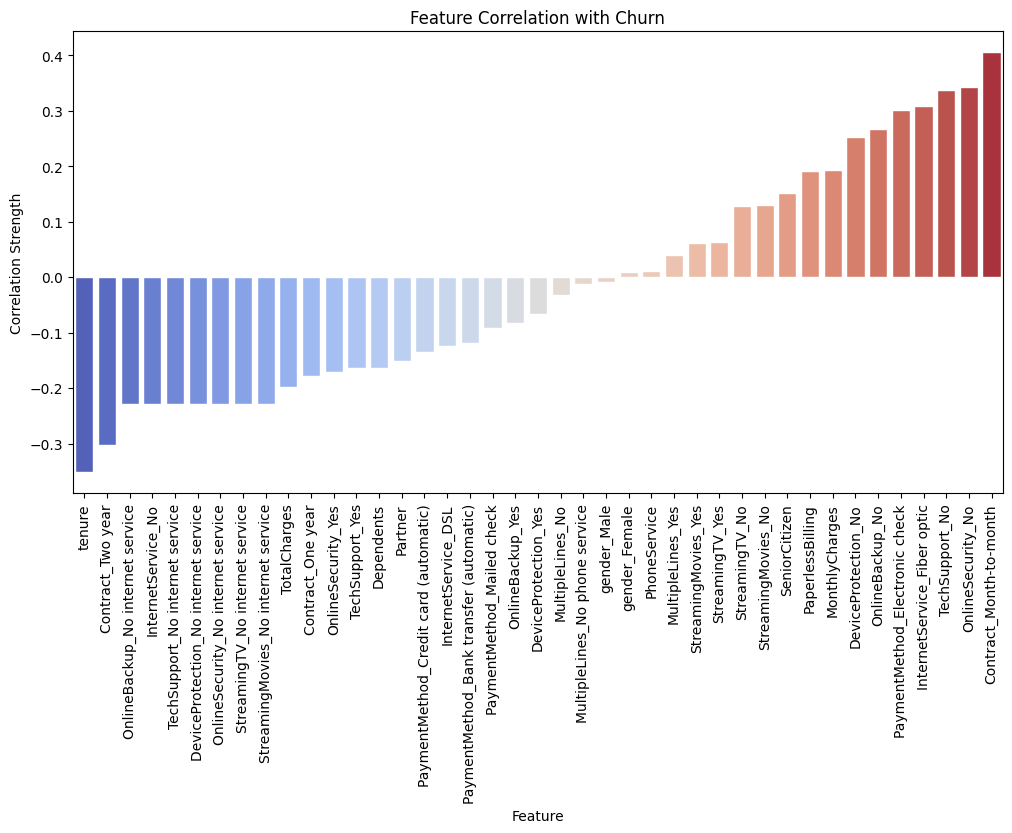

<Figure size 640x480 with 0 Axes>

In [8]:
# Isolate features
features_df = encoded_telco_data.drop(columns='Churn')

# Creating dataframe containing the correlation of each feature with our target variable
feature_target_corr = pd.DataFrame({'feature': features_df.columns, 'correlation': corr_mat['Churn'][1:]})
feature_target_corr = feature_target_corr.sort_values(by='correlation')

# Plot positive values in red and negative values in blue
f, ax = plt.subplots(figsize=(12,6))
sns.set_style("whitegrid")
sns.barplot(data=feature_target_corr,
             x='feature',
            y='correlation',
            palette='coolwarm')

plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Correlation Strength')
plt.title('Feature Correlation with Churn')
plt.show()
plt.clf()

In [9]:
print(f"Correlation between StreamingTV_No and StreamingMovies_No: " + str(corr_mat["StreamingTV_No"]["StreamingMovies_No"]))
print(f"Correlation between PaperlessBilling and MonthlyCharges: " + str(corr_mat["PaperlessBilling"]["MonthlyCharges"]))

cols_to_drop = [col for col in encoded_telco_data if "No internet service" in col]
encoded_telco_data = encoded_telco_data.drop(columns=cols_to_drop)

Correlation between StreamingTV_No and StreamingMovies_No: 0.5377730397498407
Correlation between PaperlessBilling and MonthlyCharges: 0.35214996779598723


In [ ]:
print(telco_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7043 non-null   bool   
 1   customerID        7043 non-null   object 
 2   gender            7043 non-null   object 
 3   SeniorCitizen     7043 non-null   bool   
 4   Partner           7043 non-null   bool   
 5   Dependents        7043 non-null   bool   
 6   tenure            7043 non-null   int64  
 7   PhoneService      7043 non-null   bool   
 8   MultipleLines     7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  Contract          7043 non-null   object 


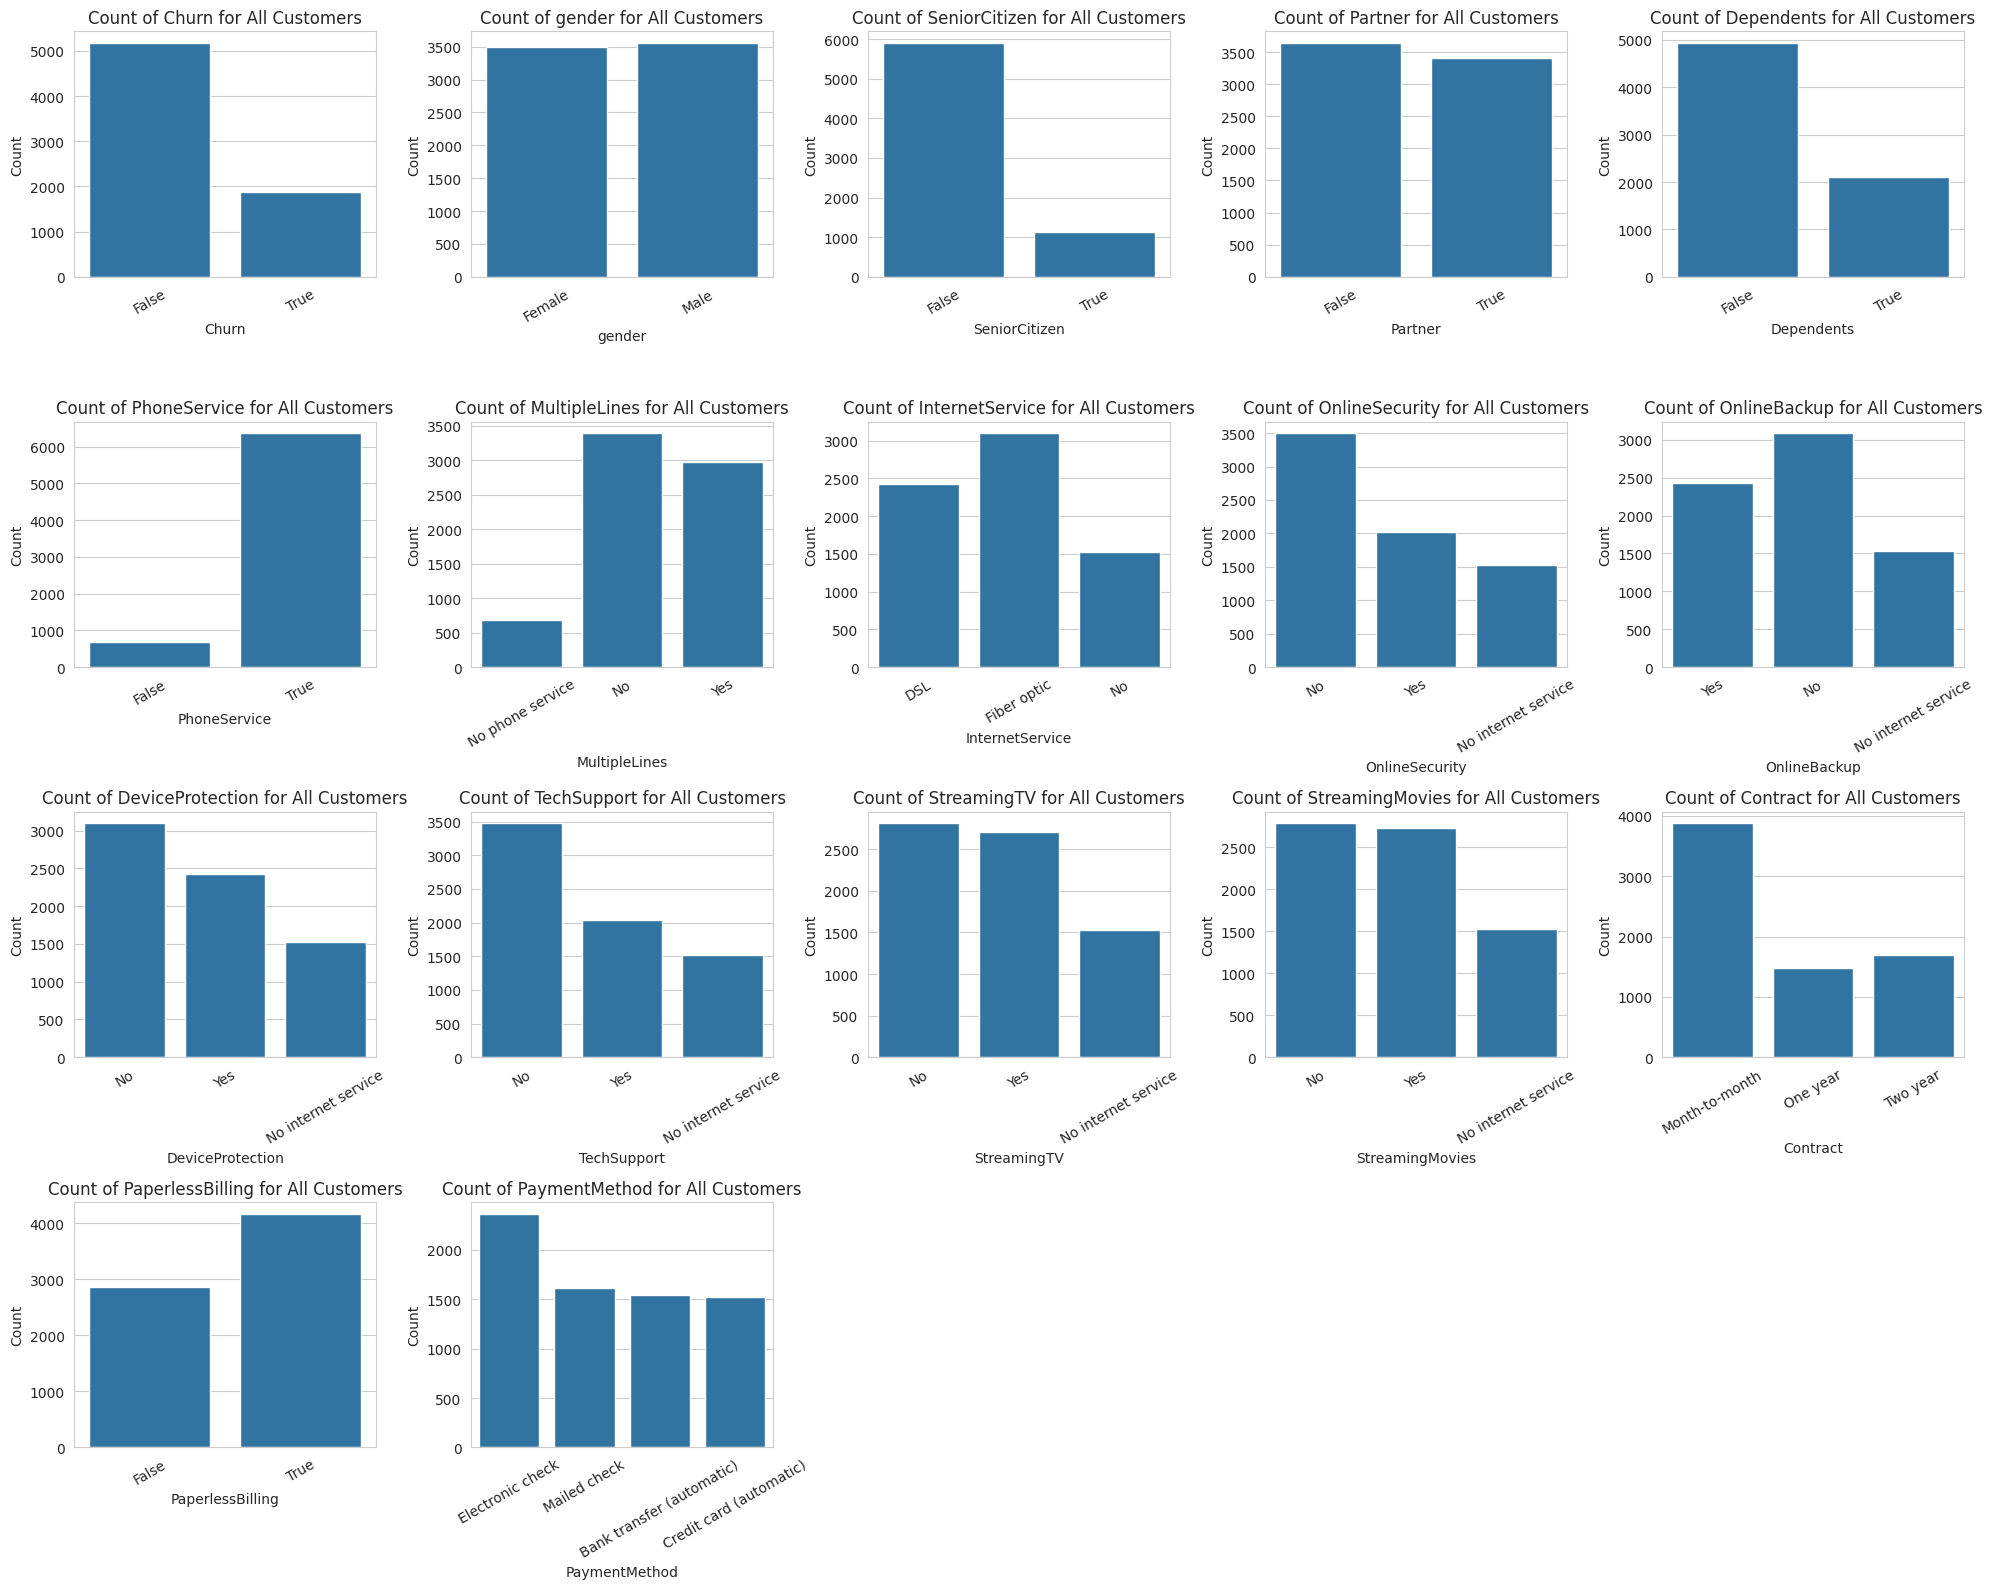

<Figure size 640x480 with 0 Axes>

In [10]:
telco_countplots = telco_data.copy()
telco_countplots = telco_data.select_dtypes(exclude=[int, float])
telco_countplots.drop(columns=["customerID"], inplace=True)

f, ax = plt.subplots(4, 5, figsize=(20, 16))
ax = ax.flatten()

for i, col in enumerate(telco_countplots.columns):
    sns.countplot(data=telco_countplots, x=col, ax=ax[i])
    ax[i].set_title(f'Count of {col} for All Customers')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

    # Set and rotate x-axis labels
    ax[i].tick_params(axis='x', rotation=30)

# Hide empty subplots if the number of columns is less than 20
for ax in ax[len(telco_countplots.columns):]:
    ax.axis('off')

plt.tight_layout()
plt.show()
plt.clf()

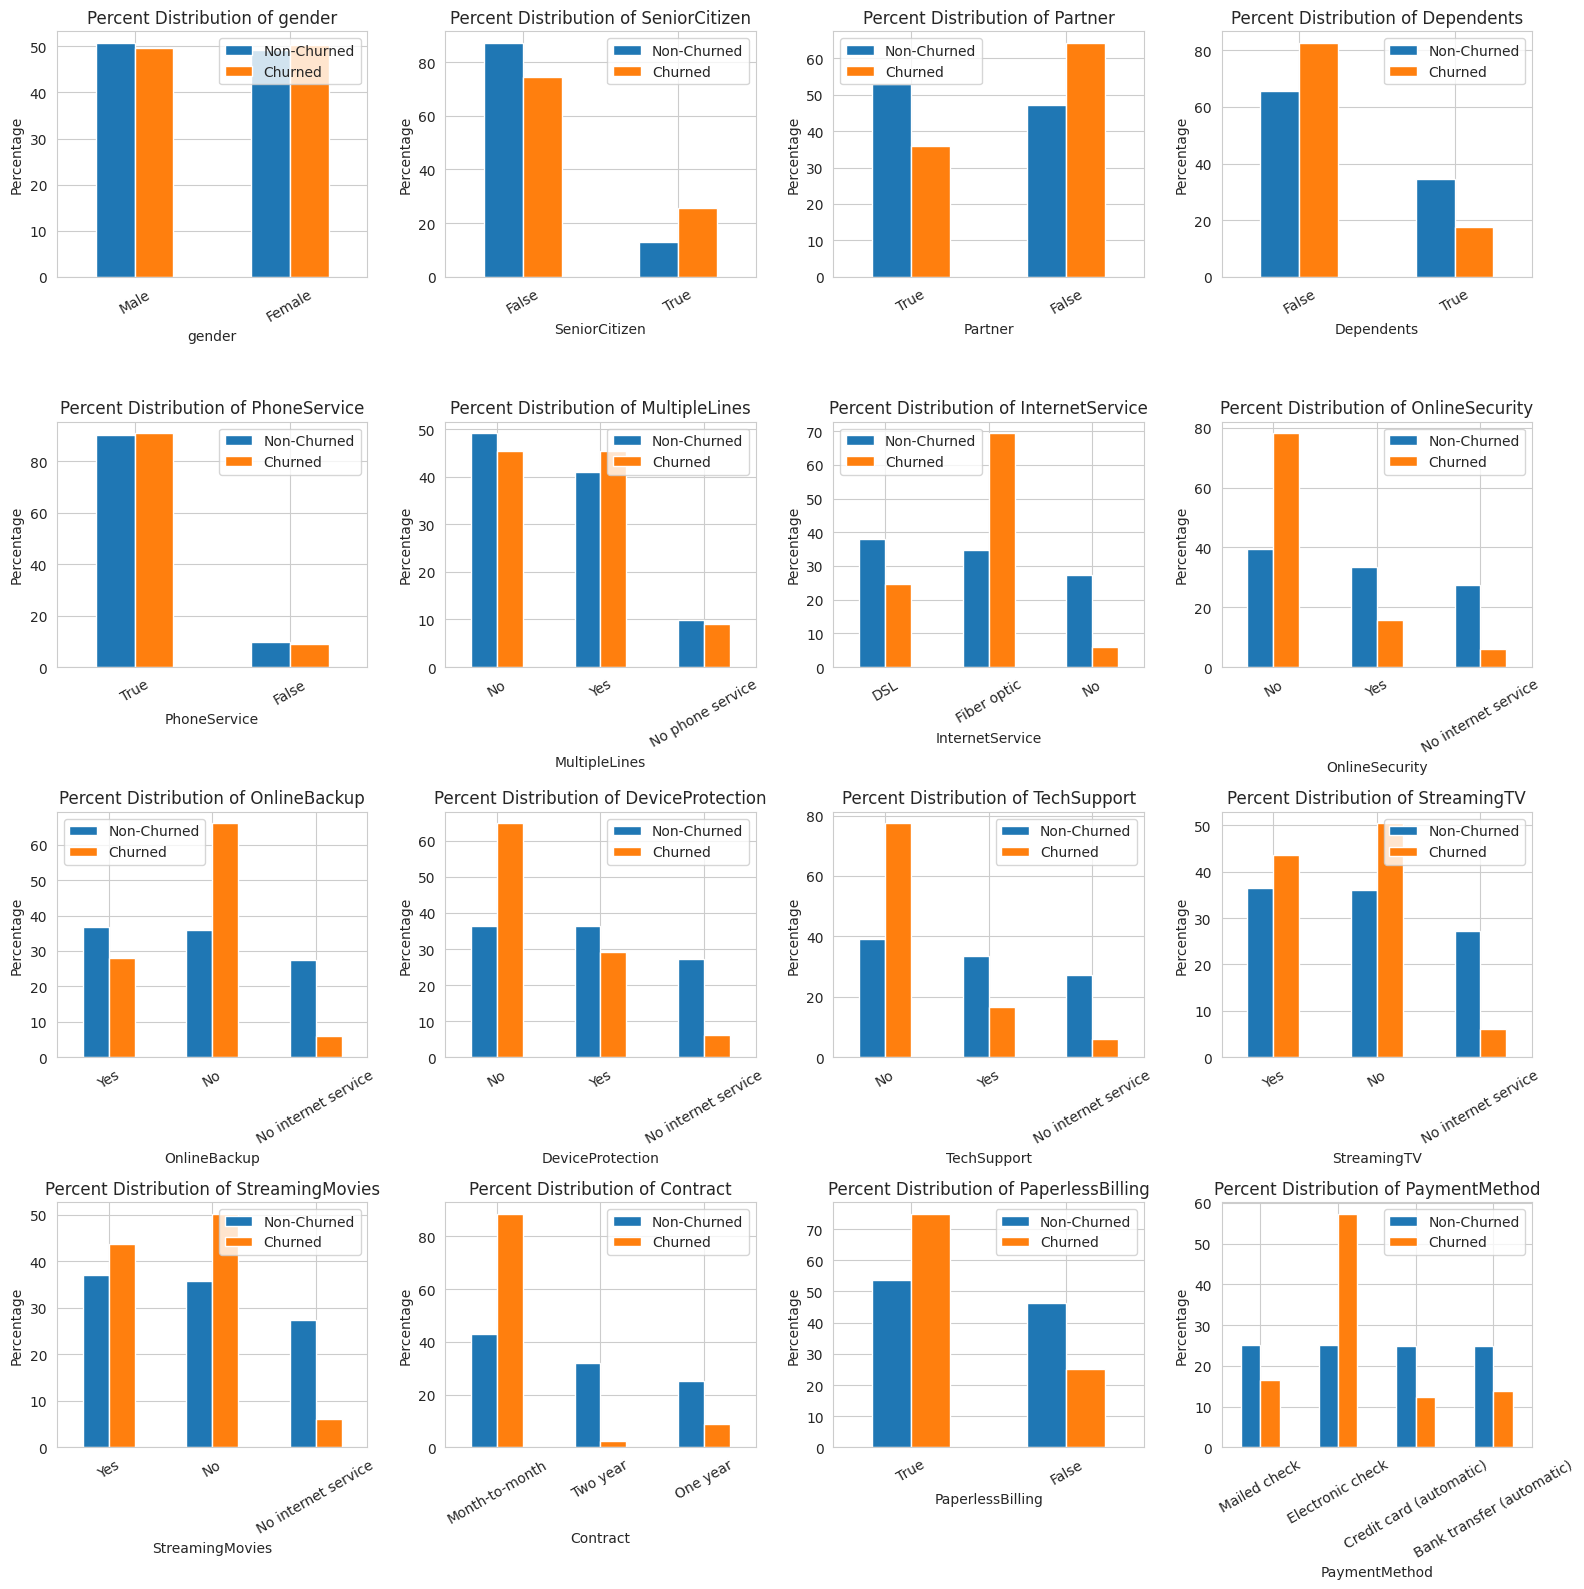

<Figure size 640x480 with 0 Axes>

In [11]:
telco_categorical = telco_data.select_dtypes(exclude=[int, float])
telco_categorical.drop(columns=["customerID"], inplace=True)

churn_categorical = telco_categorical[telco_categorical["Churn"] == True]
no_churn_categorical = telco_categorical[telco_categorical["Churn"] == False]

f, ax = plt.subplots(4, 4, figsize=(16, 16))
ax = ax.flatten()

for i, col in enumerate(telco_categorical.drop(columns="Churn").columns):
    # Create temporary dataframe
    telco_pct = pd.DataFrame()

    # Percent distribution of each variable for a given column for non-churned customers
    no_churn_pct = (100 * no_churn_categorical[col].value_counts()/no_churn_categorical.shape[0]).reset_index()
    no_churn_pct.rename(columns={"count": "Non-Churned"}, inplace=True)
    # Do the same for the subset of the population that have churned
    churn_pct = (100 * churn_categorical[col].value_counts()/churn_categorical.shape[0]).reset_index()
    churn_pct.rename(columns={"count": "Churned"}, inplace=True)

    # Merge the two dataframes
    telco_pct = pd.merge(no_churn_pct, churn_pct, on=col)

    # Plot
    telco_pct.plot.bar(x=col, ax=ax[i])
    ax[i].set_title(f'Percent Distribution of {col}')
    ax[i].set_ylabel('Percentage')

    # Set and rotate x-axis labels
    ax[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()
plt.clf()

In [13]:
print(telco_data.describe())

            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000


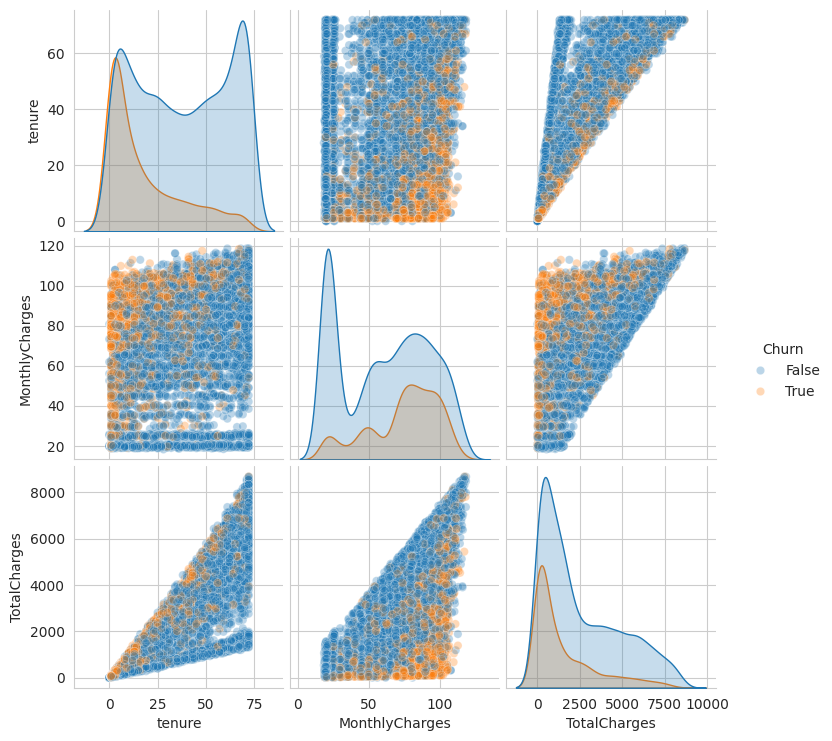

<Figure size 640x480 with 0 Axes>

In [12]:
telco_nums = telco_data.select_dtypes(include=[int, float])
telco_nums["Churn"] = telco_data["Churn"]

sns.pairplot(data=telco_nums, hue="Churn", plot_kws={'alpha': 0.3})
plt.show()
plt.clf()

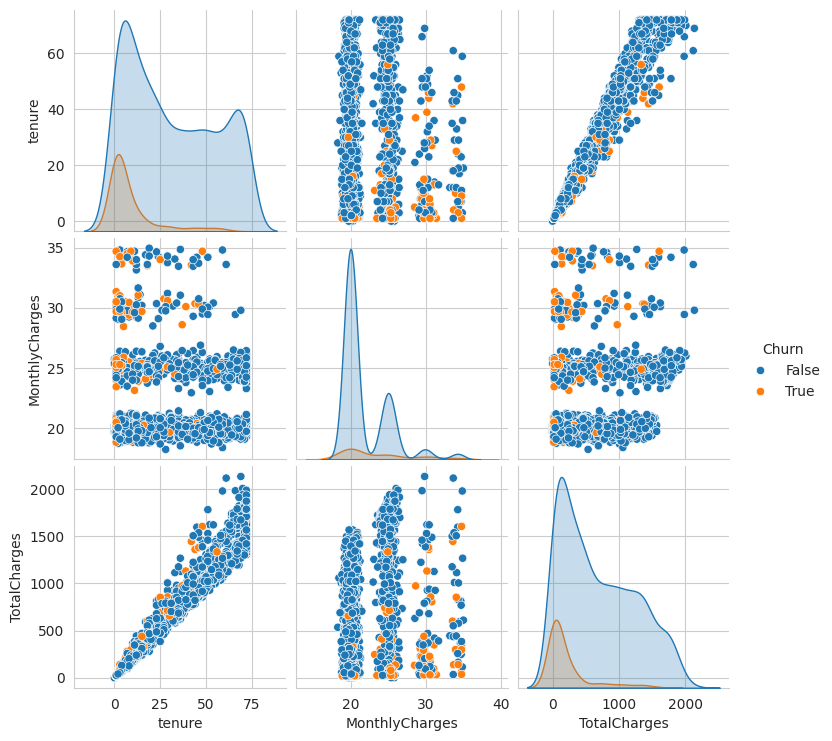

<Figure size 640x480 with 0 Axes>

In [14]:
telco_less_than_35 = telco_nums[telco_nums["MonthlyCharges"] < 35]

sns.pairplot(data=telco_less_than_35, hue="Churn")
plt.show()
plt.clf()

In [15]:
print("Summary Statistics of Non-Churned Customers")
print(telco_nums[telco_nums["Churn"] == False].describe())

print("\nSummary Statistics of Churned Customers")
print(telco_nums[telco_nums["Churn"] == True].describe())

Summary Statistics of Non-Churned Customers
            tenure  MonthlyCharges  TotalCharges
count  5174.000000     5174.000000   5174.000000
mean     37.569965       61.265124   2549.911442
std      24.113777       31.092648   2329.954215
min       0.000000       18.250000      0.000000
25%      15.000000       25.100000    572.900000
50%      38.000000       64.425000   1679.525000
75%      61.000000       88.400000   4262.850000
max      72.000000      118.750000   8672.450000

Summary Statistics of Churned Customers
            tenure  MonthlyCharges  TotalCharges
count  1869.000000     1869.000000   1869.000000
mean     17.979133       74.441332   1531.796094
std      19.531123       24.666053   1890.822994
min       1.000000       18.850000     18.850000
25%       2.000000       56.150000    134.500000
50%      10.000000       79.650000    703.550000
75%      29.000000       94.200000   2331.300000
max      72.000000      118.350000   8684.800000


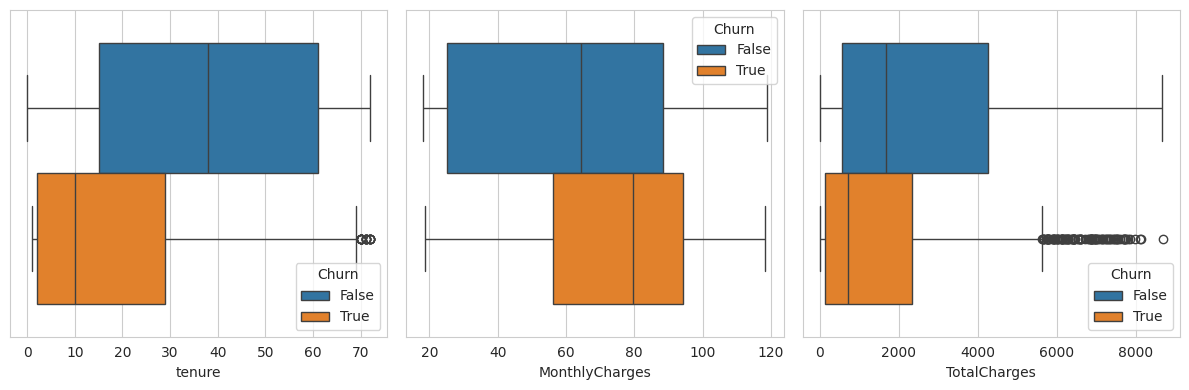

<Figure size 640x480 with 0 Axes>

In [16]:
f, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

for i, col in enumerate(telco_nums.drop(columns="Churn").columns):
    sns.boxplot(data=telco_nums, x=col, y=np.array([""]* len(telco_nums)), hue="Churn", ax=ax[i])

plt.tight_layout()
plt.show()
plt.clf()

In [17]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 16.1 MB/s eta 0:00:00


In [18]:
import optuna

In [20]:
# Using a robust scaler to better handle outliers
scaler = RobustScaler()
numerical_features = encoded_telco_data.select_dtypes(include=[int, float])
scaled_data = scaler.fit_transform(numerical_features)

# Convert the scaled data back to a DataFrame
scaled_df = pd.DataFrame(scaled_data, columns=numerical_features.columns)

# Adding it back to the encoded features
categorical_features = encoded_telco_data.select_dtypes(exclude=[int, float])
encoded_df = categorical_features.join(scaled_df)
#Split features and target column
X_data = encoded_df.drop(columns="Churn")
y_data = encoded_df["Churn"]

classifier_names = ["LogisticRegression",
                    "RandomForestClassifier",
                    "KNeighborsClassifier",
                    "GradientBoostingClassifier",
                    "SVC",
                    "AdaBoostClassifier"]

# Optuna Hyperparameter Tuning

# Define an objective function to be maximized
def objective(trial):
   # Suggest values for the hyperparameters using a trial object
    classifier_name = trial.suggest_categorical("classifier", classifier_names)

    if classifier_name == "LogisticRegression":
        lr_c = trial.suggest_float("lr_c", 1e-2, 10, log=True)
        classifier_obj = LogisticRegression(C=lr_c, max_iter=250)

    elif classifier_name == "RandomForestClassifier":
        rfc_max_depth = trial.suggest_int("rfc_max_depth", 2, 32, log=True)
        rfc_max_samples = trial.suggest_float("rfc_max_samples", 0.2, 1)
        classifier_obj = RandomForestClassifier(max_depth=rfc_max_depth, max_samples=rfc_max_samples, n_estimators=50)

    elif classifier_name == "KNeighborsClassifier":
        knc_n_neighbors = trial.suggest_int("knc_n_neighbors", 3, 10)
        classifier_obj = KNeighborsClassifier(n_neighbors=knc_n_neighbors)

    elif classifier_name == "GradientBoostingClassifier":
        gbc_learning_rate = trial.suggest_float("gbc_learning_rate", 1e-4, 1, log=True)
        classifier_obj = GradientBoostingClassifier(learning_rate=gbc_learning_rate)

    elif classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-2, 10, log=True)
        classifier_obj = SVC(C=svc_c, gamma="auto")

    else:
        abc_learning_rate = trial.suggest_float("abc_learning_rate", 1e-4, 1, log=True)
        classifier_obj = AdaBoostClassifier(learning_rate=abc_learning_rate)

    f1_score = cross_val_score(classifier_obj, X_data, y_data, cv=5, scoring="f1", n_jobs=-1).mean()

    return f1_score
    optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_f1 = study.best_value

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)

[I 2025-11-01 05:44:55,731] A new study created in memory with name: no-name-7ec910cc-fe23-4ab2-9d6b-234effe3226d
[I 2025-11-01 05:45:00,061] Trial 0 finished with value: 0.5760260020297233 and parameters: {'classifier': 'LogisticRegression', 'lr_c': 0.012534262723336485}. Best is trial 0 with value: 0.5760260020297233.
[I 2025-11-01 05:45:01,832] Trial 1 finished with value: 0.5759195137520993 and parameters: {'classifier': 'RandomForestClassifier', 'rfc_max_depth': 13, 'rfc_max_samples': 0.47453558233509235}. Best is trial 0 with value: 0.5760260020297233.
[I 2025-11-01 05:45:08,221] Trial 2 finished with value: 0.5845495400866891 and parameters: {'classifier': 'GradientBoostingClassifier', 'gbc_learning_rate': 0.14100701318042624}. Best is trial 2 with value: 0.5845495400866891.
[I 2025-11-01 05:45:08,376] Trial 3 finished with value: 0.5994490338067051 and parameters: {'classifier': 'LogisticRegression', 'lr_c': 5.891283209244143}. Best is trial 3 with value: 0.5994490338067051.
[I

Best Hyperparameters: {'classifier': 'LogisticRegression', 'lr_c': 7.5064271146461214}
Best F1 Score: 0.5998654265307901


In [21]:
def metric_report(y_true, y_pred):
    confusion_mat = confusion_matrix(y_true, y_pred)
    accuracy = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred), 3)
    recall = round(recall_score(y_true, y_pred), 3)
    f1 = round(f1_score(y_true, y_pred), 3)

    print("Confusion Matrix")
    print(confusion_mat)
    print(f"\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1: {f1}")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

lr = LogisticRegression(C=best_params["lr_c"], max_iter=250)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

metric_report(y_test, y_pred)

Confusion Matrix
[[931 105]
 [149 224]]

Accuracy: 0.82
Precision: 0.681
Recall: 0.601
F1: 0.638


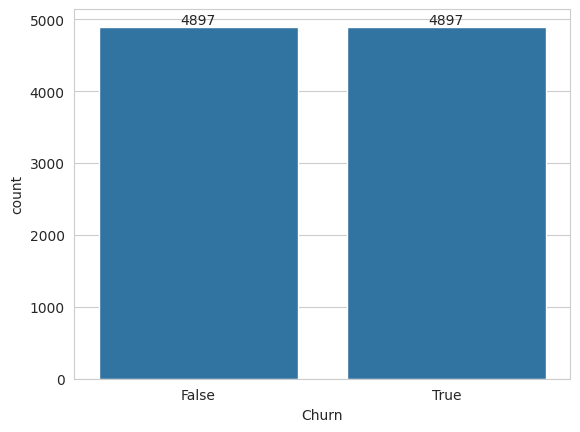

<Figure size 640x480 with 0 Axes>

In [22]:
# Resampling
resample = SMOTETomek(random_state=42)
X_res, y_res = resample.fit_resample(X_data, y_data)

ax = sns.countplot(x=y_res)
ax.bar_label(ax.containers[0])
plt.show()
plt.clf()

In [23]:
classifier_names = ["LogisticRegression",
                    "RandomForestClassifier",
                    "KNeighborsClassifier",
                    "GradientBoostingClassifier",
                    "SVC",
                    "AdaBoostClassifier"]

# Optuna Hyperparameter Tuning

# Define an objective function to be maximized
def objective(trial):
    # Suggest values for the hyperparameters using a trial object
    classifier_name = trial.suggest_categorical("classifier", classifier_names)

    if classifier_name == "LogisticRegression":
        lr_c = trial.suggest_float("lr_c", 1e-2, 10, log=True)
        model = LogisticRegression(C=lr_c, max_iter=500)

    elif classifier_name == "RandomForestClassifier":
        rfc_max_depth = trial.suggest_int("rfc_max_depth", 2, 32, log=True)
        rfc_max_samples = trial.suggest_float("rfc_max_samples", 0.2, 1)
        model = RandomForestClassifier(max_depth=rfc_max_depth, max_samples=rfc_max_samples, n_estimators=50)

    elif classifier_name == "KNeighborsClassifier":
        knc_n_neighbors = trial.suggest_int("knc_n_neighbors", 3, 10)
        model = KNeighborsClassifier(n_neighbors=knc_n_neighbors)

    elif classifier_name == "GradientBoostingClassifier":
        gbc_learning_rate = trial.suggest_float("gbc_learning_rate", 1e-4, 1, log=True)
        model = GradientBoostingClassifier(learning_rate=gbc_learning_rate)

    elif classifier_name == "SVC":
        svc_c = trial.suggest_float("svc_c", 1e-2, 10, log=True)
        model = SVC(C=svc_c, gamma="auto")

    else:
        abc_learning_rate = trial.suggest_float("abc_learning_rate", 1e-4, 1, log=True)
        model = AdaBoostClassifier(learning_rate=abc_learning_rate)

    model.fit(X_res, y_res)
    y_pred = model.predict(X_data)

    f1 = f1_score(y_data, y_pred)

    return f1

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)
best_params = study.best_params
best_f1 = study.best_value

print("Best Hyperparameters:", best_params)
print("Best F1 Score:", best_f1)

Best Hyperparameters: {'classifier': 'RandomForestClassifier', 'rfc_max_depth': 23, 'rfc_max_samples': 0.8837804990933722}
Best F1 Score: 0.9284587059442398


In [24]:
rfc = RandomForestClassifier(max_depth=best_params["rfc_max_depth"], max_samples=best_params["rfc_max_samples"])
# Training on resampled dataset
rfc.fit(X_res, y_res)
# Checking performance on orginal dataset
y_pred = rfc.predict(X_data)

metric_report(y_data, y_pred)

Confusion Matrix
[[5000  174]
 [ 104 1765]]

Accuracy: 0.961
Precision: 0.91
Recall: 0.944
F1: 0.927


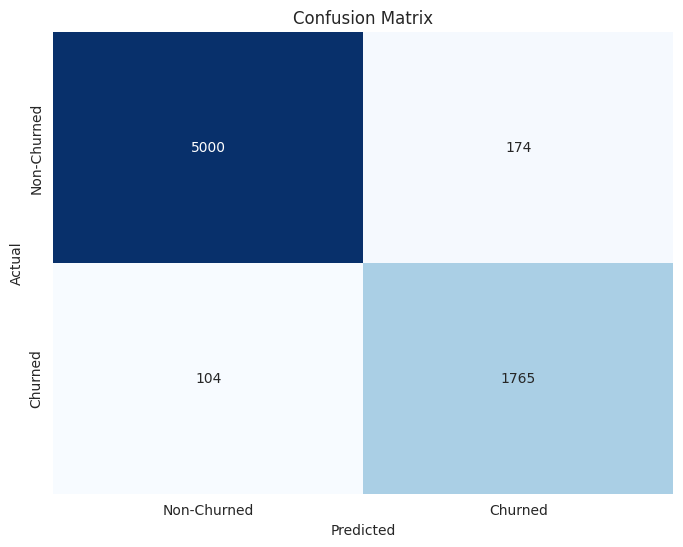

In [25]:
conf_mat = confusion_matrix(y_data, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Churned', 'Churned'],
            yticklabels=['Non-Churned', 'Churned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()